# Group Analysis

In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src import plotting
from src.stats import calculate_p, cluster_correction
from scipy import ndimage

In [3]:
process = 'Group_Analysis'
top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
input_path = f'{top_path}/data/interim'
out_path = f'{top_path}/data/interim/{process}'
figure_path = f'{top_path}/reports/figures/{process}'
Path(out_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

regress_gaze=False
overwrite = False

In [4]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [5]:
def load_files(files, cat=None, cat_order=None, subj_exclude=[]):
    group = []
    subjs = []
    for file in files:
        subj = file.split('/')[-1].split('_')[0]
        if subj not in subj_exclude: 
            subjs.append(subj)
            if 'pkl' in file:
                df = pd.read_pickle(file)
            else:
                df = pd.read_csv(file)
            df['subj'] = subj
            if 'Unnamed: 0' in df.columns:
                df.drop(columns=['Unnamed: 0'], inplace=True)
            group.append(df)
    group = pd.concat(group)
    if cat and cat_order:
        cat_type = pd.CategoricalDtype(categories=cat_order, ordered=True)
        group[cat] = group[cat].astype(cat_type)
    return group, subjs

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

## Pairwise decoding

['sub-03', 'sub-02', 'sub-01', 'sub-05', 'sub-04', 'sub-08', 'sub-06', 'sub-09', 'sub-11', 'sub-10', 'sub-12']


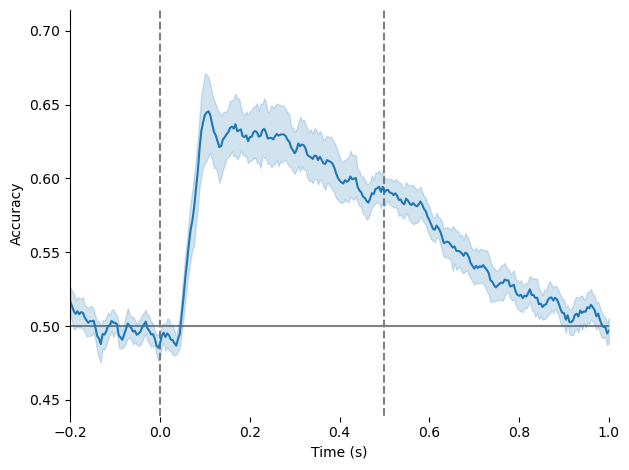

In [6]:
pairwise_decoding, subjs = load_files(glob(f'{input_path}/PairwiseDecoding/*reg-gaze-{regress_gaze}.csv.gz'))
print(subjs)
decoding_avg = pairwise_decoding.groupby(['time', 'subj']).mean(numeric_only=True).reset_index()
_, ax = plt.subplots()
ymin, ymax = decoding_avg['distance'].min(), decoding_avg['distance'].max()
sns.lineplot(x='time', y='distance', data=decoding_avg, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')     
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=0.5, xmin=decoding_avg.time.min(), xmax=decoding_avg.time.max(),
        colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([decoding_avg.time.min(), decoding_avg.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
# plt.savefig(f'{figure_path}/pairwise-decoding_nvideos-250_reg-gaze-{regress_gaze}.png')

## Feature - EEG Decoding

In [7]:
def mean_of_arrays(series):
    # Stack arrays vertically and compute mean along the first axis (rows)
    return np.nanmean(np.vstack(series),axis=0)

# Define a function to calculate the 2.5% and 97.5% percentiles of an array
def compute_confidence_intervals(arr):
    lower = np.nanpercentile(arr, 2.5)
    upper = np.nanpercentile(arr, 97.5)
    return lower, upper

def cluster_correction_df(group):
    feature_name = group['feature'].iloc[0]
    rs = group['r'].to_numpy()
    ps = group['p'].to_numpy()
    r_nulls = np.vstack(group['r_null'].to_numpy())
    corrected_ps = cluster_correction(rs, ps, r_nulls, desc=f'{feature_name} progress')
    return  pd.Series(corrected_ps, index=group['time'])

def calculate_p_df(row):
    r_value = row['r']  # The 'r' value for the current row
    r_null_array = row['r_null']  # The 'r_null' array for the current row
    return calculate_p(r_null_array, r_value, n_perm_=len(r_null_array), H0_='greater')

In [8]:
def plot_decoding(results_, features_, out_file=None, cols=3):

    # Make the subplots and remove empty axes
    rows = int(np.ceil(len(features_)/cols))
    _, axes = plt.subplots(rows, cols,
                           figsize=(cols*2, rows*2), 
                           sharex=True, sharey=True,
                           constrained_layout=True)
    axes = axes.flatten()
    if len(axes) > len(features_):
        trim_axs(axes, len(features_)-len(axes))

    # Find the same y across features
    ymin, ymax = results_['lower_ci'].min(), results_['upper_ci'].max()

    for ax, (feature, time_corr) in zip(axes, results_.groupby('feature')):
        sns.lineplot(x='Time (s)', y='Explained variance ($r^2$)',
                      data=time_corr, ax=ax)
        ax.fill_between(x=time_corr['Time (s)'],
                        y1=time_corr['lower_ci'],
                        y2=time_corr['upper_ci'],
                        color='gray', alpha=0.3)
        
        # Mark the start and stop of the video and 0 encoding performance
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr['Time (s)'].min(),
                  xmax=time_corr['Time (s)'].max(),
                  colors='gray', linestyles='solid', zorder=0)
        
        # Plot significance lines 
        label, n = ndimage.label(time_corr['p_corrected'] < 0.05)
        if n > 0:
            for i in range(n):
                cluster_time = time_corr.loc[label == i+1, 'Time (s)']
                ax.hlines(xmin=cluster_time.min(),
                           xmax=cluster_time.max(), y=-0.05,
                           colors='gray')
        
        # Set x and y limits 
        ax.set_xlim([time_corr['Time (s)'].min(),
                    time_corr['Time (s)'].max()])
        ax.set_ylim([ymin, ymax])

        # Remove boxes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)
        plt.close()

In [10]:
overwrite = True
group_feature_file = f'{out_path}/feature_decoding.csv'
if not os.path.exists(f'{out_path}/feature_decoding.csv') or overwrite: 
    files = glob(f'{input_path}/FeatureDecoding/*reg-gaze-{regress_gaze}_decoding.pkl')
    df, subjs = load_files(files)
    df['feature'] = df.feature.astype('str')
    print(f'{subjs=}')

    # Average across subjects
    result = df.groupby(['time', 'feature']).agg({
        'r': 'mean',  # For scalar values, use the built-in 'mean' function
        'r_null': mean_of_arrays,  # For numpy arrays, use the custom function
        'r_var': mean_of_arrays
    }).reset_index()

    # Compute the confidence intervals across subjec ts
    result[['lower_ci', 'upper_ci']] = result['r_var'].apply(lambda arr: pd.Series(compute_confidence_intervals(arr)))

    # Calculate the p values across subjects
    result['p'] = result.apply(calculate_p_df, axis=1)

    # Perform cluster correction on the p values
    result = result.sort_values(by=['feature', 'time']).reset_index(drop=True)
    corrected_p_series = result.groupby('feature').apply(cluster_correction_df)
    corrected_p_series = corrected_p_series.apply(pd.Series).stack().reset_index(name='p_corrected')
    result = result.merge(corrected_p_series, on=['feature', 'time']) # Combine wiht original data frame

    # Make a column for plotting the significant clusters
    result['sig_plotting'] = np.nan
    result.loc[result.p_corrected < 0.05, 'sig_plotting'] = -0.05

    # Rename columns for pretty plotting 
    result.rename(columns={'r': 'Explained variance ($r^2$)',
                        'time': 'Time (s)'}, inplace=True)

    # Drop the array columns which have been used to compute p values and CIs 
    result.drop(columns=['r_null', 'r_var'], inplace=True)

    # Save the output to disk
    result.to_csv(group_feature_file, index=False)
else:
    result = pd.read_csv(group_feature_file)

subjs=['sub-04', 'sub-12', 'sub-01', 'sub-05', 'sub-06', 'sub-10', 'sub-03', 'sub-09', 'sub-02', 'sub-11', 'sub-08']


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/169541459.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.vstack(series),axis=0)
valence progress: 100%|██████████| 5000/5000 [00:18<00:00, 276.63it/s]


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/1828719247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_results['feature'] = annotated_results['feature'].astype(cat_type)
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/898988470.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


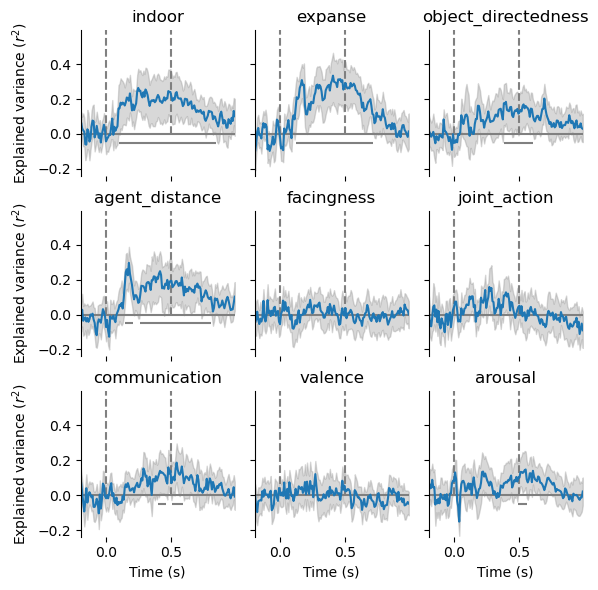

In [12]:
annotated_results = result[~result['feature'].str.contains('alexnet', na=False)]
annotated_results = result[~result['feature'].str.contains('moten', na=False)]
cat_type = pd.CategoricalDtype(categories=annotated_features, ordered=True)
annotated_results['feature'] = annotated_results['feature'].astype(cat_type)
plot_decoding(annotated_results, annotated_features)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/411723545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moten_results['feature'] = moten_results['feature'].astype(cat_type)
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/898988470.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


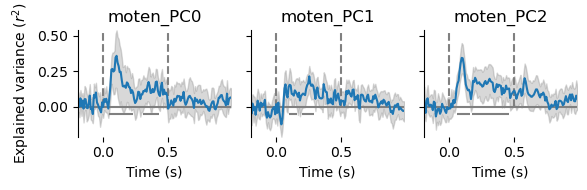

In [13]:
moten_results = result[result['feature'].str.contains('moten', na=False)]
moten_features = [feature for feature in result.feature.unique() if 'moten' in feature]
cat_type = pd.CategoricalDtype(categories=moten_features, ordered=True)
moten_results['feature'] = moten_results['feature'].astype(cat_type)
plot_decoding(moten_results, moten_features)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/1847906538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alexnet_results['feature'] = alexnet_results['feature'].astype(cat_type)
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_67779/898988470.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


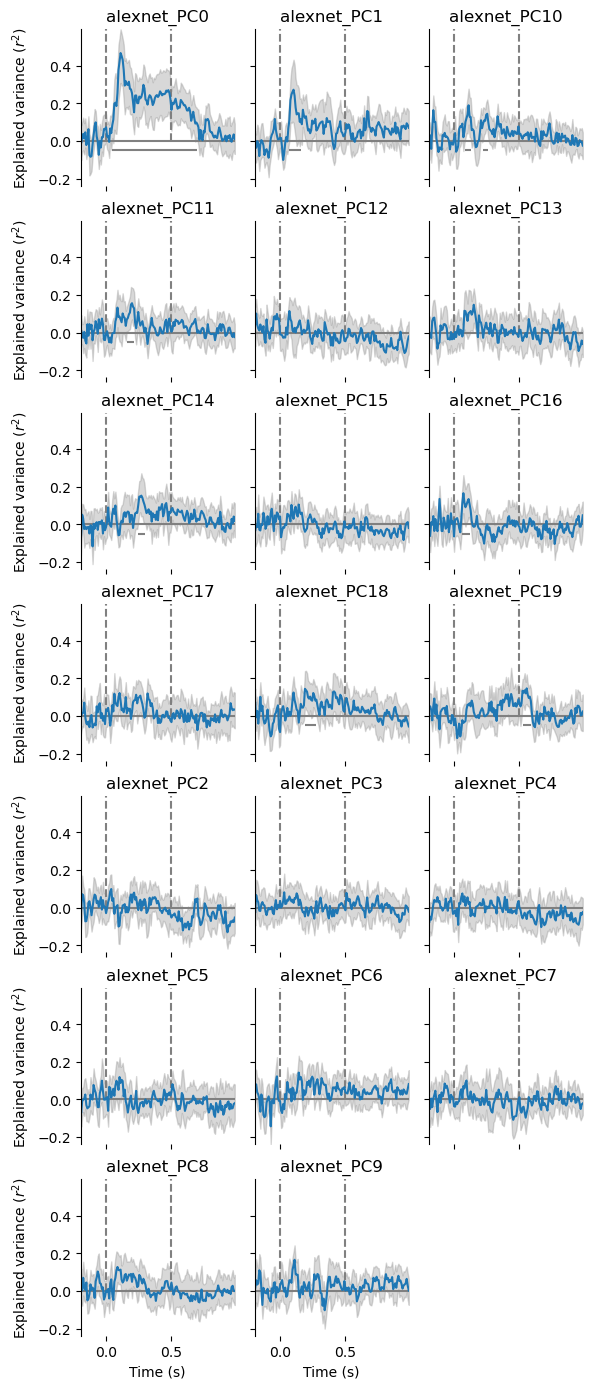

In [14]:
alexnet_results = result[result['feature'].str.contains('alexnet', na=False)]
alexnet_features = [feature for feature in result.feature.unique() if 'alexnet' in feature]
cat_type = pd.CategoricalDtype(categories=alexnet_features, ordered=True)
alexnet_results['feature'] = alexnet_results['feature'].astype(cat_type)
plot_decoding(alexnet_results, alexnet_features)

## fMRI-EEG Decoding

In [ ]:
def plot_fmri_eeg_decoding(rsa, out_file=None):
    roi_group = rsa.groupby('roi_name')
    _, axes = plt.subplots(3, 3, sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['score'].min(), rsa['score'].max()
    for ax, (roi, roi_corr) in zip(axes, roi_group):
        sns.lineplot(x='time', y='score', data=roi_corr, ax=ax)
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Prediction (r)')
        else:
            ax.set_ylabel('')

        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='both', length=0)

        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=roi_corr.time.min(), xmax=roi_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([roi_corr.time.min(), roi_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)
        plt.close()

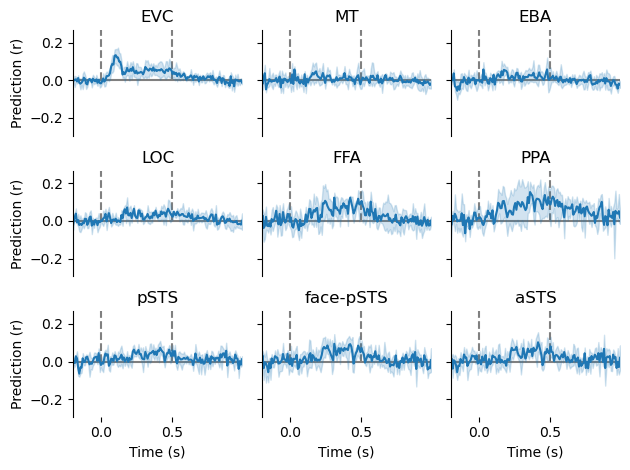

In [ ]:
rsa, subjs = load_files(glob(f'{input_path}/fMRIDecoding/*reg-gaze-{regress_gaze}_decoding.pkl'),
                        cat='roi_name', cat_order=rois,
                        subj_include=extra_test)
# out_file = f'{figure_path}/fMRI_EEG_reg-gaze-{regress_gaze}_decoding.png'
plot_fmri_eeg_decoding(rsa)

## Gaze decoding

In [27]:
# def plot_feature_gaze_decoding(results, out_file=None):
#     _, ax = plt.subplots()
#     sns.barplot(x='feature', y='r', data=results, errorbar=None, ax=ax, color='gray')
#     sns.swarmplot(x='feature', y='r', hue='subj', data=results, ax=ax, palette='husl')
#     ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
#         colors='black', linestyles='solid', zorder=1)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.set_xticklabels(features, rotation=45, ha='right')
#     ax.set_xlabel('')
#     ax.set_ylabel('Prediction (r)')
#     ax.legend(bbox_to_anchor=(.95, .95))
#     plt.tight_layout()
#     if out_file is not None:
#         plt.savefig(out_file)
#         plt.close()

In [ ]:
# results, _ = load_files(glob(f'{input_path}/GazeDecoding/*decoding.csv'),
#                     cat='feature', cat_order=features,
#                     subj_include=extra_test)
# results['subj'] = results['subj'].astype(pd.CategoricalDtype(categories=extra_test, ordered=True))
# # out_file = f'{figure_path}/feature_gaze_rsa.png'
# plot_feature_gaze_decoding(results)